# Figure 11

Figure 11. As in Figure 1, except for mean annual MCS precipitation on MCS days. Panels c and e are masked for grids where HIST has a value of less than 1 mm day-1.

### Read in the MCS day and precipitation data

In [1]:
import warnings
warnings.filterwarnings("ignore")

In [2]:
import xarray as xr

data_dir = "../data"
analysis='mcs_precip'
subset='annual'

simulation_names = {'historical': 'HIST', 
                    'future_4p5': 'EoC 4.5', 
                    'future_8p5': 'EoC 8.5'}

precip_data = {}

for sim in ['historical', 'future_4p5', 'future_8p5']:

    precip_data[sim] = {}
        
    ds_precip = xr.open_dataset(f"{data_dir}/{analysis}/{sim}_{subset}/{analysis}_{sim}_years_sums_75km.nc")

    ds_precip = ds_precip.rename({'mcs_mask': 'mcs_precip_ratio'})

    precip_data[sim]['years_sums'] = ds_precip
    precip_data[sim]['annual_mean'] = ds_precip.mean('time')

### Read in the MCS day data

In [3]:
import xarray as xr

data_dir = "../data"
analysis='mcs_days'
subset='monthly'

day_data = {}

for sim in simulation_names.keys():

    day_data[sim] = {}
        
    ds_day = xr.open_mfdataset(f"{data_dir}/{analysis}/{sim}_{subset}/*.nc")
    
    ds_day = ds_day.resample(time='AS-OCT').sum('time')
    
    ds_day = ds_day.compute()

    ds_day = ds_day.rename({'MCS_Days': 'mcs_precip_ratio'})

    day_data[sim]['years_sums'] = ds_day
    day_data[sim]['annual_mean'] = ds_day.mean('time')

### Calculate the MCS precipitation to MCS day ratios

1) Get the ratio of mcs precip to mcs day for each year in each epoch
2) Calculate the annual mean of this ratio for each epoch
3) Find the difference in ratios between HIST and EoC 4.5 and EoC 8.5
4) Use the annual ratios in each epoch to calculate statistical significance

In [4]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

plt.rcParams['figure.figsize'] = 20, 10

prec_per_day = {}

for i, simulation in enumerate(['historical', 'future_4p5', 'future_8p5', 'delta_future_4p5', 'delta_future_8p5']):

    prec_per_day[simulation] = {}

    if simulation in ['historical', 'future_4p5', 'future_8p5']:

        day = day_data[simulation]['years_sums']
        precip = precip_data[simulation]['years_sums']
    
        prec_per_day[simulation]['years_ppd'] = precip / day
    
        day = day_data[simulation]['annual_mean']
        precip = precip_data[simulation]['annual_mean']
    
        prec_per_day[simulation]['mean_ppd'] = precip / day

    else:
        
        futr_str = simulation.replace("delta_", "")

        futr_d = prec_per_day[futr_str]['mean_ppd']
        hist_d = prec_per_day['historical']['mean_ppd']

        dif = futr_d - hist_d

        dif = dif.where(hist_d >= 1)
        
        prec_per_day[simulation]['mean_ppd'] =  dif

        prec_per_day[simulation]['years_ppd'] = None

### Draw the maps

<Figure size 3800x4000 with 0 Axes>

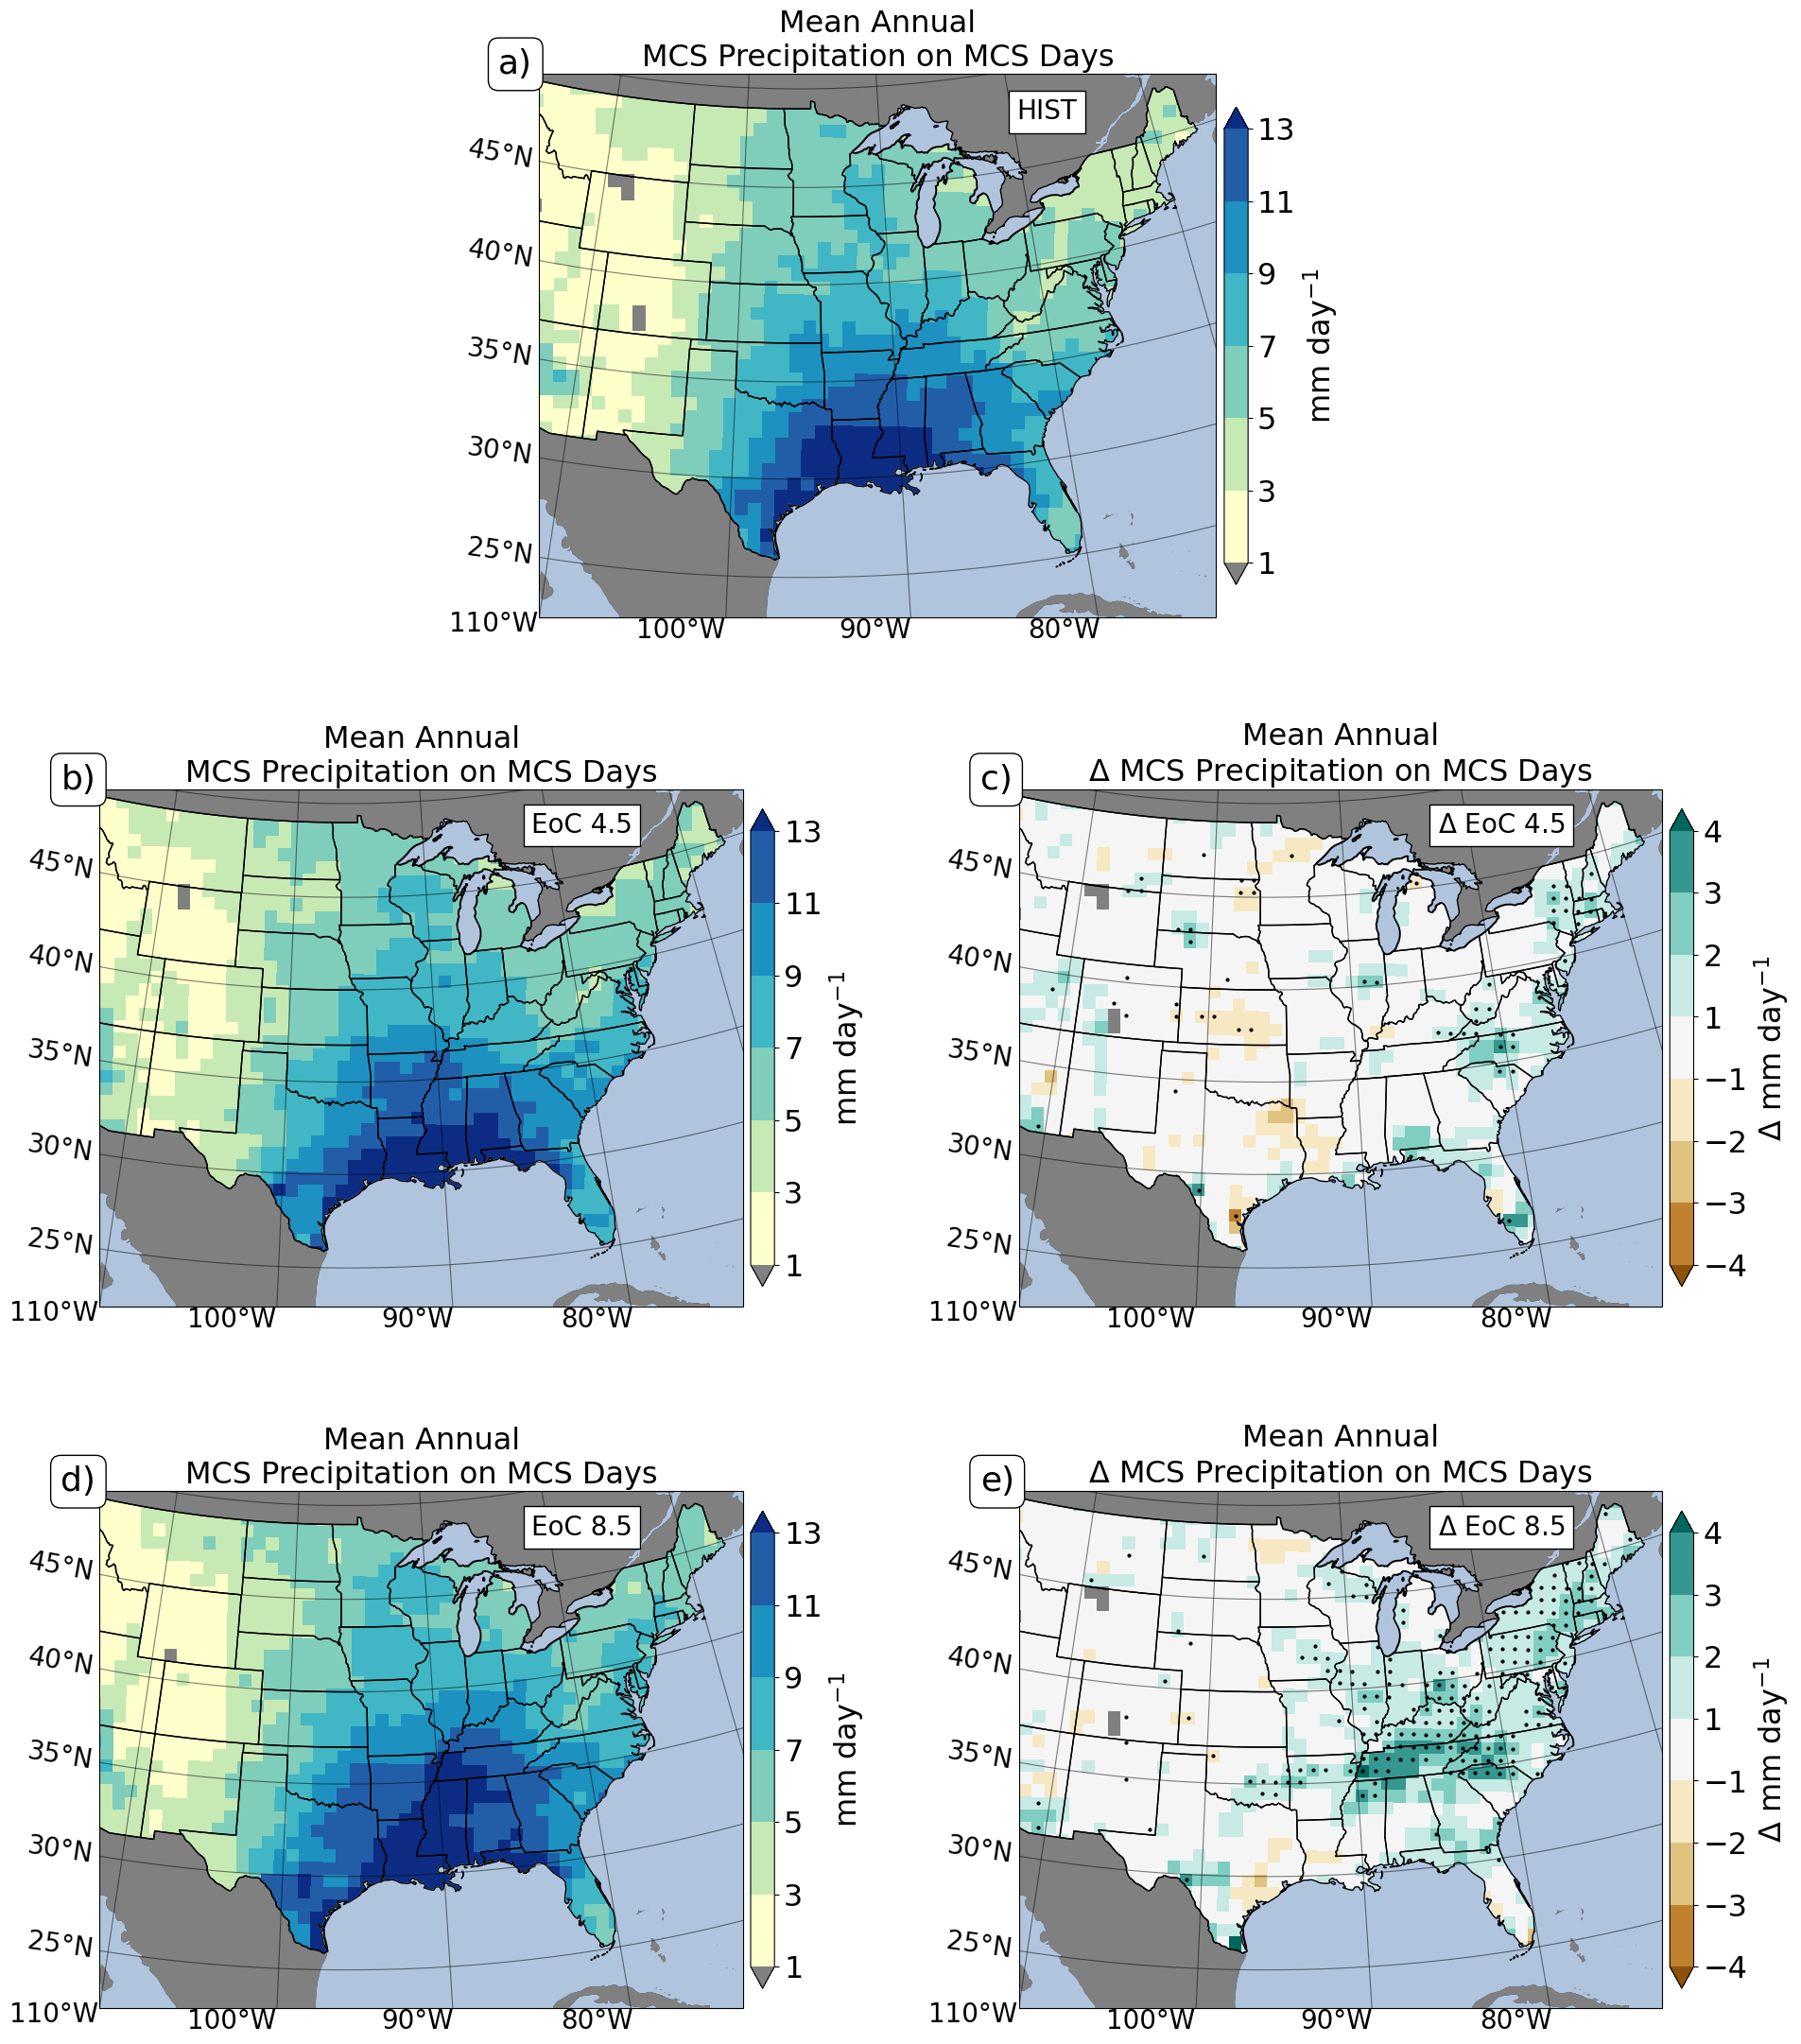

In [5]:
from mapping import setup_map, spec_ax, get_color_dict
from stats import grid_significance
import cartopy.crs as ccrs
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

plt.rcParams['xtick.labelsize'] = 23
plt.rcParams['ytick.labelsize'] = 23
plt.rcParams['axes.titlesize'] = 23
plt.rcParams['axes.labelsize'] = 23

color_info = get_color_dict(11)

fig = plt.figure(figsize=(38,40))

simulation_dispy = {'historical': 'HIST',
                    'future_4p5': 'EoC 4.5',
                    'delta_future_4p5': '$\Delta$ EoC 4.5',
                    'future_8p5': 'EoC 8.5',
                    'delta_future_8p5': '$\Delta$ EoC 8.5'}

fig = plt.figure(figsize=(23, 27))

for ax_pos, (sim_name, sim_abbr) in enumerate(simulation_dispy.items()):

    ax = spec_ax(ax_pos, nrows=3, ncols=4, fig=fig, five_panel=True)

    ax = setup_map(label_num=ax_pos+1, ax=ax, draw_outlines=False)
    
    ax.annotate(f"{sim_abbr}", (0.75,0.93), 
                xycoords='axes fraction', ha='center', va='center',
                fontsize=20, bbox=dict(boxstyle='square', facecolor='w', alpha=1), 
                color='k', zorder=25)

    mmp = ax.pcolormesh(prec_per_day[sim_name]['mean_ppd'].lon, prec_per_day[sim_name]['mean_ppd'].lat, 
                        prec_per_day[sim_name]['mean_ppd']['mcs_precip_ratio'],
                        transform=ccrs.PlateCarree(), 
                        cmap=color_info[sim_name]['cmap'], norm=color_info[sim_name]['norm'], zorder=5)

    cbar = plt.colorbar(mmp, ax=ax, shrink=0.85, extend='both', pad=0.01)
    
    if sim_name in ['historical', 'future_4p5', 'future_8p5']:

        ax.set_title(f"Mean Annual\nMCS Precipitation on MCS Days")
        
        cbar.set_label(label="mm day$^{-1}$")

    else:
        
        futr_str = sim_name.replace("delta_", "")
        
        ax.set_title(f"Mean Annual\n$\Delta$ MCS Precipitation on MCS Days")
        
        cbar.set_label(label="$\Delta$ mm day$^{-1}$")

        futr = prec_per_day[futr_str]['years_ppd']['mcs_precip_ratio']
        hist = prec_per_day['historical']['years_ppd']['mcs_precip_ratio']

        hist = hist.where(prec_per_day['historical']['mean_ppd']['mcs_precip_ratio'] >= 1)
        futr = futr.where(prec_per_day['historical']['mean_ppd']['mcs_precip_ratio'] >= 1)
        
        sig = grid_significance(hist, futr)

        pts_sig = np.where(sig < 0.05)

        ax.plot(prec_per_day['historical']['mean_ppd'].lon.values[pts_sig],
                prec_per_day['historical']['mean_ppd'].lat.values[pts_sig],
                transform=ccrs.PlateCarree(), zorder=5, linestyle='None', 
                marker='.', color='k', ms=4)
        
    ax.spines['geo'].set_zorder(24)
    
#plt.savefig("Figure_11.png", dpi=200, bbox_inches='tight')

### Seasonal

Precipitation

In [6]:
import xarray as xr

data_dir = "../data"
analysis='mcs_precip'
subset='seasonal'
    
seas_precip_data = {}

for sim in ['historical', 'future_4p5', 'future_8p5']:

    seas_precip_data[sim] = {}
    
    for season in ['DJF', 'MAM', 'SON', 'JJA']:
        
        seas_precip_data[sim][season] = {}
    
        if sim in ['historical', 'future_4p5', 'future_8p5']:

            ds_precip_season = xr.open_dataset(f"../data/{analysis}/{sim}_{subset}/{analysis}_{sim}_{season}_sums_75km.nc")

            ds_precip_season = ds_precip_season.rename({'mcs_mask': 'mcs_precip_ratio'})

            seas_precip_data[sim][season]['years_sums'] = ds_precip_season
            seas_precip_data[sim][season]['annual_mean'] = ds_precip_season.mean('time')

Days

In [7]:
import xarray as xr

data_dir = "../data"
analysis='mcs_days'
subset='monthly'

season_defs = {'DJF': [12, 1, 2], 
               'MAM': [3, 4, 5], 
               'JJA': [6, 7, 8],
               'SON': [9, 10, 11]}
    
seas_days_data = {}

for sim in ['historical', 'future_4p5', 'future_8p5']:

    seas_days_data[sim] = {}
    
    if sim in ['historical', 'future_4p5', 'future_8p5']:
        
        ds = xr.open_mfdataset(f"{data_dir}/{analysis}/{sim}_{subset}/*.nc")

        for season, season_months in season_defs.items():

            seas_days_data[sim][season] = {}

            ds_season = ds.where(ds.time.dt.month.isin(season_months), drop=True)
            
            ds_season = ds_season.resample(time='AS-OCT').sum('time')
            ds_season = ds_season.rename({'MCS_Days': 'mcs_precip_ratio'})
            ds_season = ds_season.compute()
 
            seas_days_data[sim][season]['years_sums'] = ds_season
            seas_days_data[sim][season]['annual_mean'] = ds_season.mean('time')

### Calculate mcs precipitation to mcs days ratio

In [8]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

plt.rcParams['figure.figsize'] = 20, 10

prec_per_day = {}

for i, simulation in enumerate(['historical', 'future_4p5', 'future_8p5', 'delta_future_4p5', 'delta_future_8p5']):

    prec_per_day[simulation] = {}

    for season in ['DJF', 'MAM', 'JJA', 'SON']:

        prec_per_day[simulation][season] = {}

        if simulation in ['historical', 'future_4p5', 'future_8p5']:
    
            day = seas_days_data[simulation][season]['years_sums']
            precip = seas_precip_data[simulation][season]['years_sums']
        
            prec_per_day[simulation][season]['years_ppd'] = precip / day
        
            day_mean = seas_days_data[simulation][season]['annual_mean']
            precip_mean = seas_precip_data[simulation][season]['annual_mean']
        
            prec_per_day[simulation][season]['mean_ppd'] = precip_mean / day_mean
    
        else:
            
            futr_str = simulation.replace("delta_", "")

            futr_d = prec_per_day[futr_str][season]['mean_ppd']
            hist_d = prec_per_day['historical'][season]['mean_ppd']
    
            dif = futr_d - hist_d
    
            dif = dif.where(hist_d >= 1)
            
            prec_per_day[simulation][season]['mean_ppd'] = dif
    
            prec_per_day[simulation][season]['years_ppd'] = None

### Draw maps

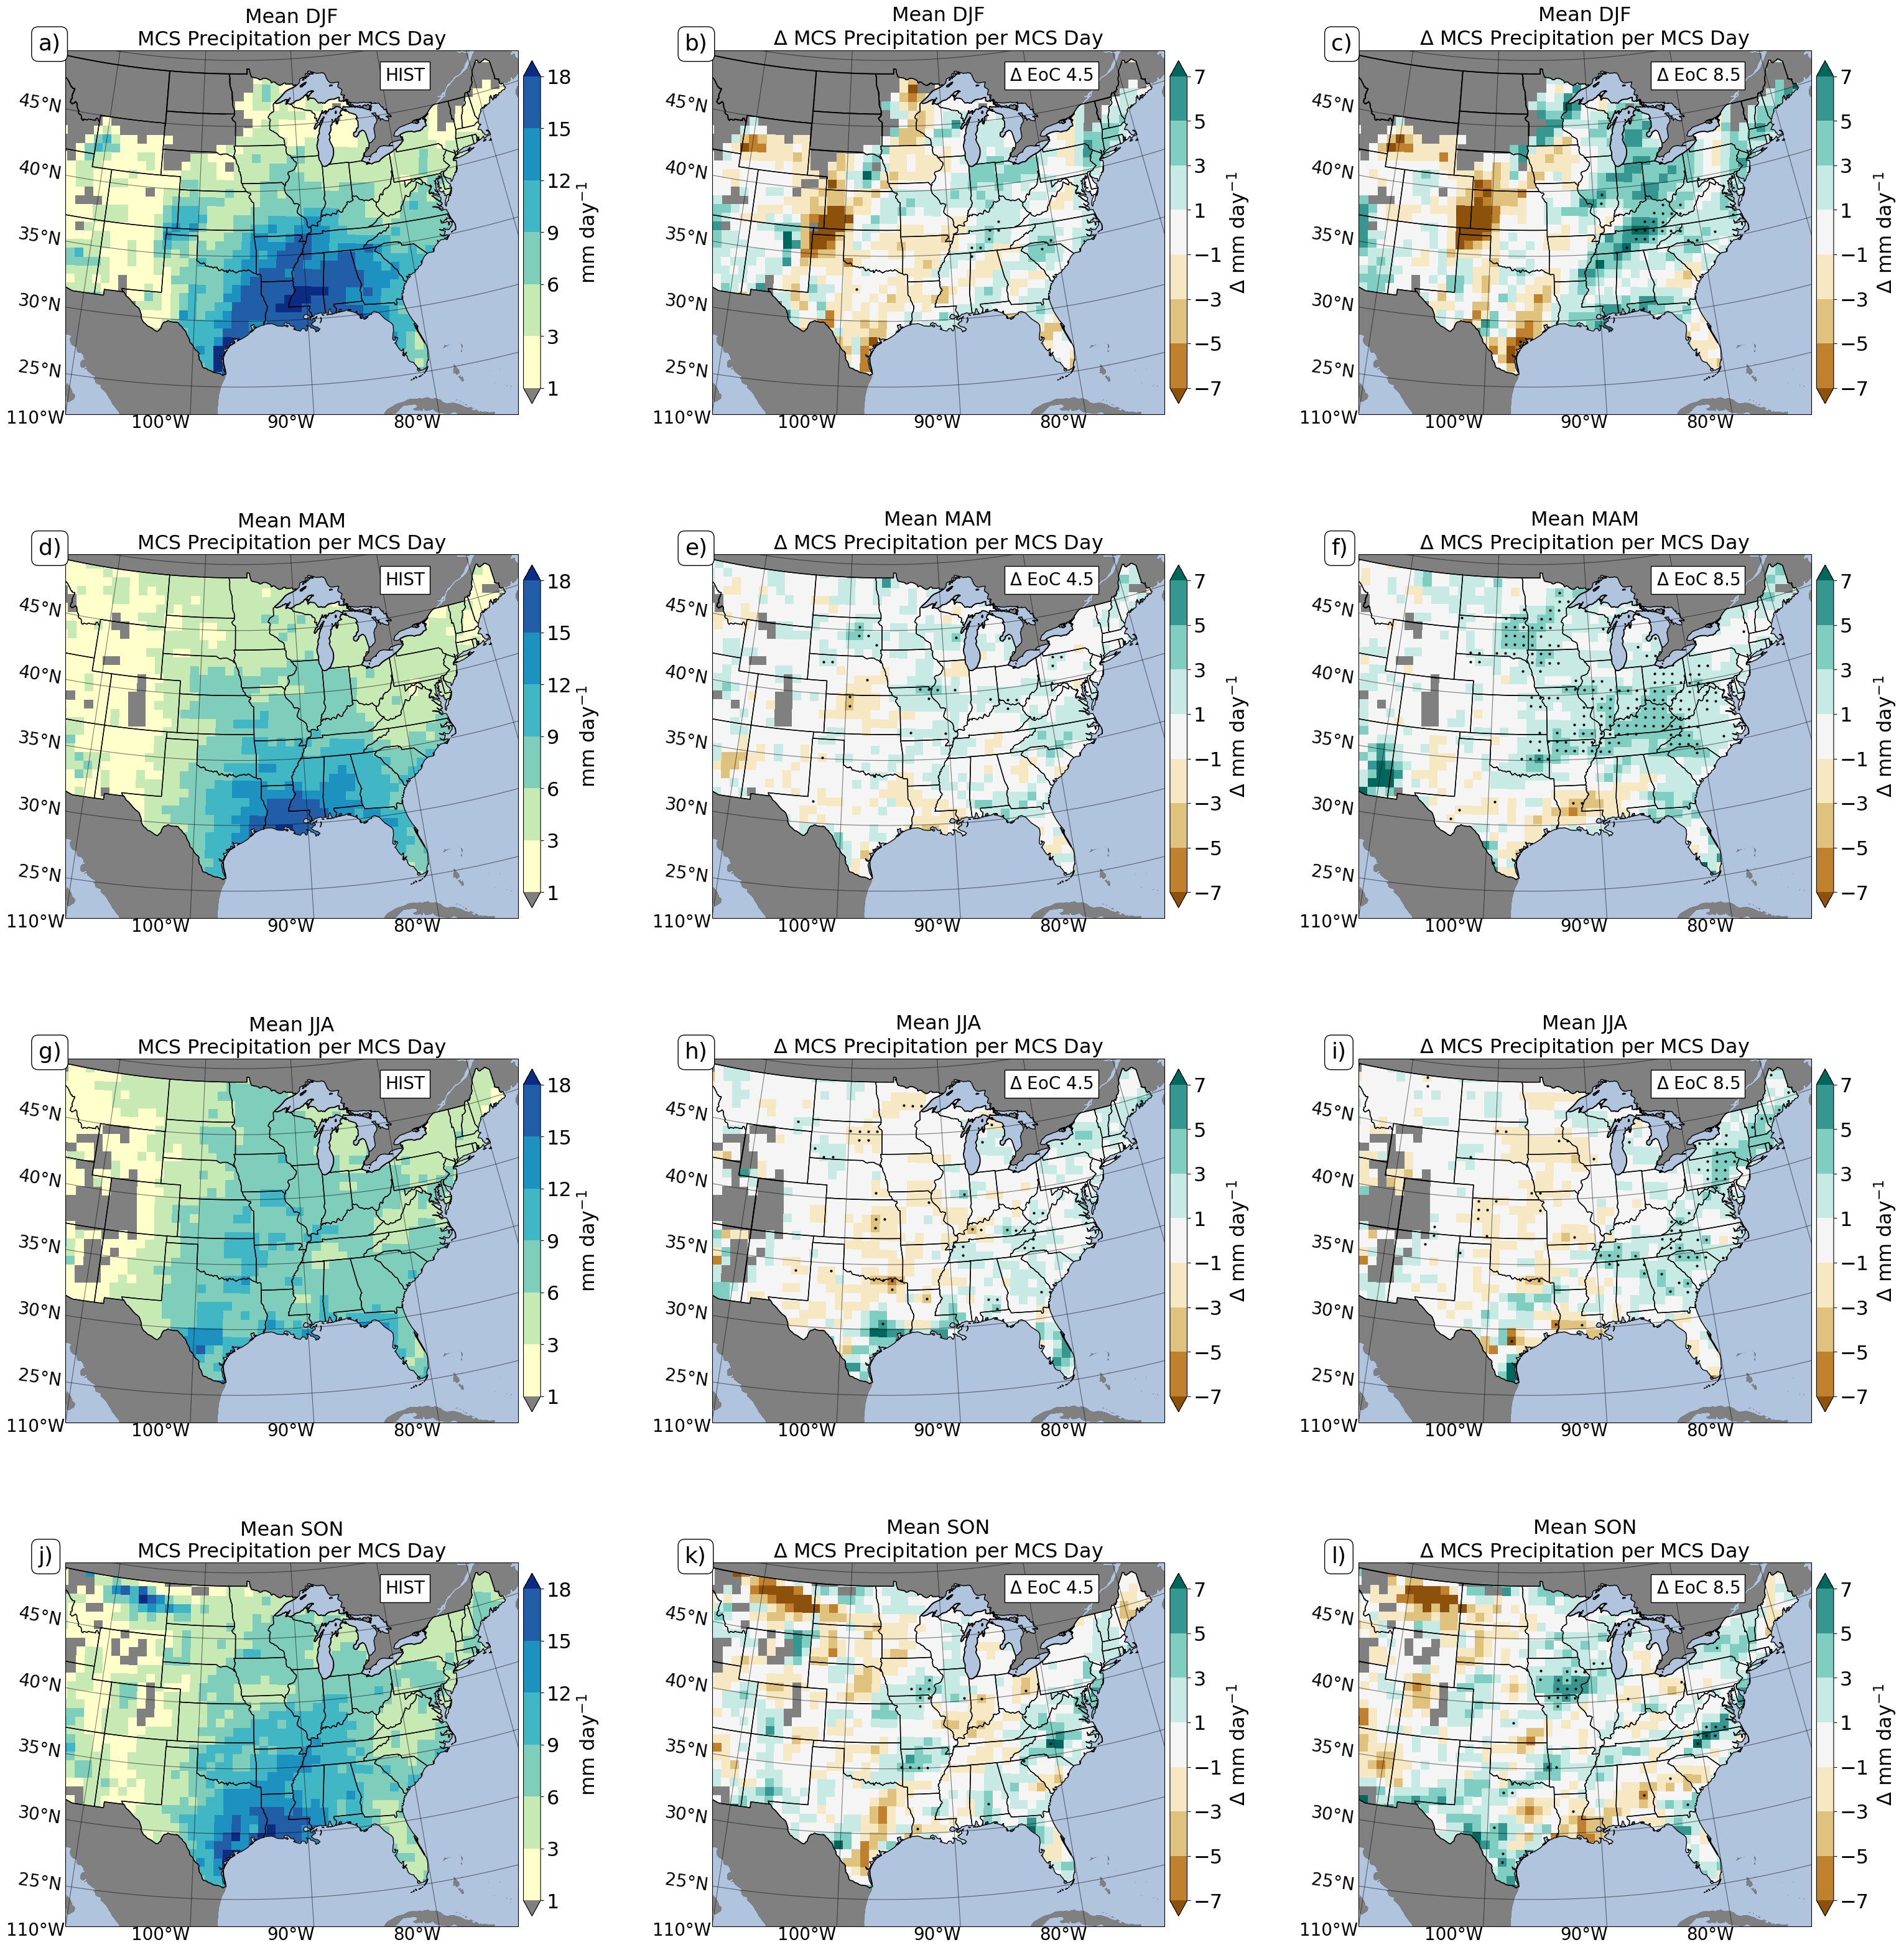

In [9]:
from mapping import setup_map, spec_ax, get_color_dict
from stats import grid_significance
import cartopy.crs as ccrs
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

plt.rcParams['xtick.labelsize'] = 23
plt.rcParams['ytick.labelsize'] = 23
plt.rcParams['axes.titlesize'] = 23
plt.rcParams['axes.labelsize'] = 23

color_info = get_color_dict('S6')

fig = plt.figure(figsize=(38,40))

simulation_dispy = {'historical': 'HIST',
                    'delta_future_4p5': '$\Delta$ EoC 4.5',
                    'delta_future_8p5': '$\Delta$ EoC 8.5'}


for snum, season in enumerate(['DJF', 'MAM', 'JJA', 'SON']):

    for ax_pos, (sim_name, sim_abbr) in enumerate(simulation_dispy.items()):

        ax = spec_ax(snum, fig, 4, 3, ax_pos)

        ax = setup_map(label_num=(snum*3) + ax_pos+1, ax=ax)

        ax.annotate(f"{sim_abbr}", (0.75,0.93), 
                    xycoords='axes fraction', ha='center', va='center',
                    fontsize=20, bbox=dict(boxstyle='square', facecolor='w', alpha=1), 
                    color='k', zorder=25)

        mmp = ax.pcolormesh(prec_per_day[sim_name][season]['mean_ppd'].lon, 
                            prec_per_day[sim_name][season]['mean_ppd'].lat, 
                            prec_per_day[sim_name][season]['mean_ppd']['mcs_precip_ratio'],
                            transform=ccrs.PlateCarree(), 
                            cmap=color_info[sim_name]['cmap'], norm=color_info[sim_name]['norm'], zorder=5)

        cbar = plt.colorbar(mmp, ax=ax, shrink=0.85, extend='both', pad=0.01)
    
        if sim_name in ['historical', 'future_4p5', 'future_8p5']:
    
            ax.set_title(f"Mean {season}\nMCS Precipitation per MCS Day")
            
            cbar.set_label(label="mm day$^{-1}$")
    
        else:
            
            futr_str = sim_name.replace("delta_", "")
            
            ax.set_title(f"Mean {season}\n$\Delta$ MCS Precipitation per MCS Day")
            
            cbar.set_label(label="$\Delta$ mm day$^{-1}$")

            hist = prec_per_day['historical'][season]['years_ppd']['mcs_precip_ratio']
            futr = prec_per_day[futr_str][season]['years_ppd']['mcs_precip_ratio']

            hist = hist.where(prec_per_day['historical'][season]['mean_ppd']['mcs_precip_ratio'] >= 1)
            futr = futr.where(prec_per_day['historical'][season]['mean_ppd']['mcs_precip_ratio'] >= 1)
            
            sig = grid_significance(hist, futr)
    
            pts_sig = np.where(sig < 0.05)
    
            ax.plot(prec_per_day[simulation][season]['mean_ppd'].lon.values[pts_sig],
                    prec_per_day[simulation][season]['mean_ppd'].lat.values[pts_sig],
                    transform=ccrs.PlateCarree(), zorder=5, linestyle='None', 
                    marker='.', color='k', ms=4)
        
        ax.spines['geo'].set_zorder(24)
    
#plt.savefig("Figure_S6.png", dpi=200, bbox_inches='tight')